<h2>Fraud: A How-to Guide</h2>

Many cases of fraud can be detected through outlier detection or other statistical analysis. A fairly well-known example is Benford’s law: http://mathworld.wolfram.com/BenfordsLaw.html. This states that transactions amounts span several orders of magnitude and are best modeled in log-space. However when converted back into normal amounts, roughly 30% of the transactions will have an initial digit of “1”, and 17% will have an initial digit of “2” etc. This is very different from most people’s intuition that each digit should have an equal probability of occurring.

In this problem, I will use density modeling to try and ensure that there are no statistical irregularities in self-generated data.

<h3>Instructions</h3>

1) Download the following data containing personal transactions over a period of several years: https://course-resources.minerva.kgi.edu/uploaded_files/mke/Y5GZpr/anonymized.csv

2) Now build the following density models for:
    - The number of transactions that occur in a single month.
    - The day in the month that a transaction will occur on.
    - Transaction size.
    
3) Create plots showing the distributions that you’ve created.

4) Sampling from these density models, create a fictitious month of personal transactions.

5) Explain what flaws still remain in your model that a forensic accountant might be able to find and determine that this was a fraudulent set of transactions.

6) (Optional) How well does the data follow Benford’s law?

In [1]:
#import libraries
import numpy as np
import pandas as pd
from sklearn.neighbors.kde import KernelDensity
import matplotlib.dates as dates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

<h2>Number of Transactions</h2>

Density models of the number of transactions are constructed at two different levels of granularity:

- The number of transactions in a month
- The number of transactions in a day

The bandwidth of the density models in this section and the rest are all manually chosen based on visual comparison between the resulting KDE plot and the original data's plot.

<h3>Number of Monthly Transactions</h3>

        Date    Amount
0  25May2016  54241.35
1  29May2017  54008.83
2  30Jun2017  54008.82
3  05Jan2017  52704.37
4  23Feb2017  52704.36


Text(0,0.5,'Number of transactions')

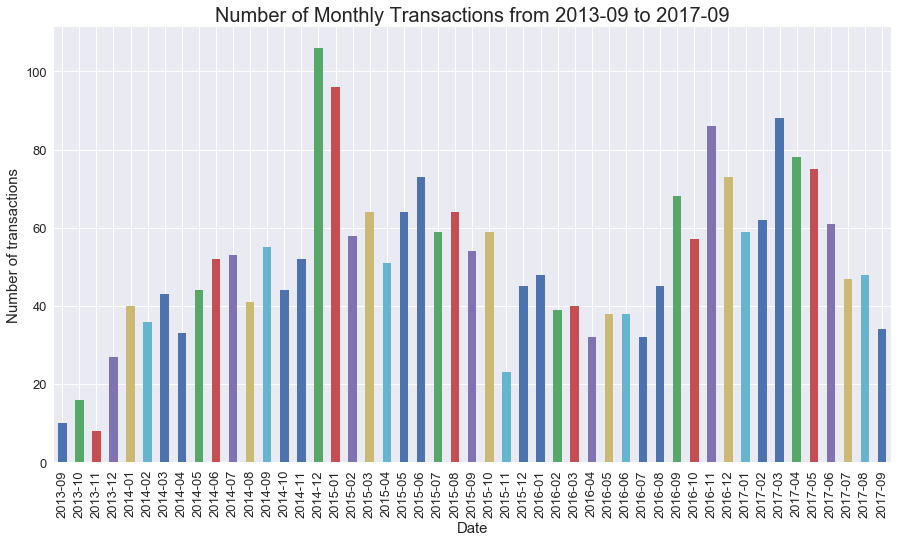

In [2]:
#import data
df = pd.read_csv("transactions.csv")

#peak at data
print(df.head(5))

#convert date from string to datetime
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
#create month-year column to get monthly time periods
df['month_year'] = df.Date.dt.to_period('M')

#group transactions based on month and year
monthly_trans = df.groupby(df['month_year']).count()

#barplot of monthly transactions
ax = monthly_trans['Date'].plot(kind='bar',figsize=(15,8),fontsize=13)
ax.set_title("Number of Monthly Transactions from 2013-09 to 2017-09", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Number of transactions", fontsize=15)

Text(0,0.5,'Number of Transactions')

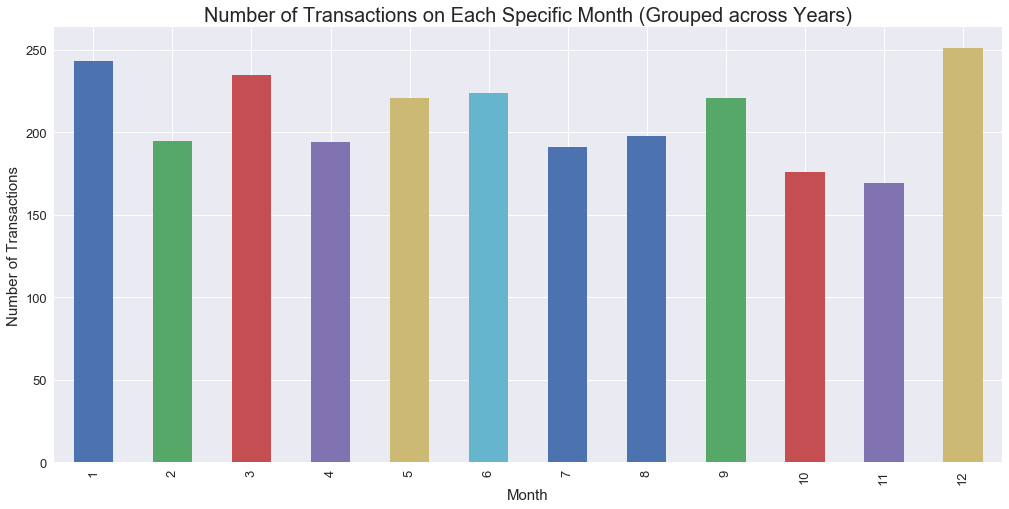

In [3]:
df['Month'] = df['Date'].dt.month
monthly_trans_grouped = df.groupby('Month').count()

#plot daily transactions
ax = monthly_trans_grouped['Amount'].plot(kind='bar',figsize=(17,8),fontsize=13)
ax.set_title("Number of Transactions on Each Specific Month (Grouped across Years)", fontsize=20)
ax.set_xlabel("Month", fontsize=15)
ax.set_ylabel("Number of Transactions", fontsize=15)

In [4]:
def plot_density_models(data, kde, title):
    
    '''
    This function makes a side-by-side plot comparing the histogram and density
    for the original data vs histogram and density for the KDE samples.
    
    Input: 
        data (arr): The data for plotting the original data histogram.
        
        kde (sklearn.neighbors.kde.KernelDensity): The kde created after fitting a kernel to the data.
        
        title (string): The title of the resulting plot.
    
    Output:
        Does not return any output, but displays two plots showing:
        - The distribution of the original data.
        - The distribution of the KDE-generated samples.
    '''
    
    plt.figure(figsize=(16,5), dpi=100)
    
    #plot hist and density for original data
    plt.subplot(1,2,1)
    sns.kdeplot(data, legend=None)
    plt.hist(data, density=True, color='#3a6ab7', alpha=0.6)
    plt.title(f"Distribution of original data: {title} \n($\mu$ = {round(np.mean(data),2)}, $\sigma$ = {round(np.std(data),2)})", size=13)
    plt.ylabel("Density")
    plt.xlabel(f"{title}")

    #plot hist and density for 1000 samples from gaussian kernel
    plt.subplot(1,2,2)
    samples = kde.sample(n_samples=1000)
    sns.kdeplot(samples.flatten(), color='#d85849')
    plt.hist(samples.flatten(), density=True, color='#d85849', alpha=0.6)
    plt.title(f"Distribution of KDE samples \n($\mu$ = {round(np.mean(samples),2)}, $\sigma$ = {round(np.std(samples),2)})", size=13)
    plt.ylabel("Density")
    plt.xlabel(f"{title}")
    plt.show()
    

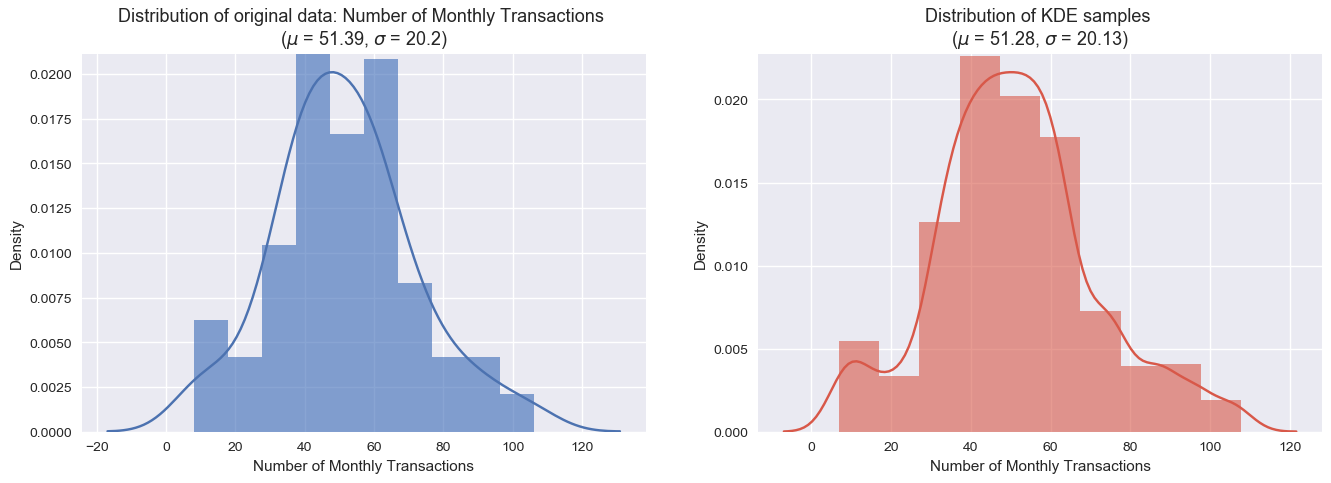

In [5]:
#monthly transactions histogram: original and kde
data = monthly_trans['Date']
monthly_trans_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(np.array(data).reshape(-1,1))
plot_density_models(data, monthly_trans_kde, "Number of Monthly Transactions" )

<h3>Number of Daily Transactions</h3>

Text(0,0.5,'Number of Transactions')

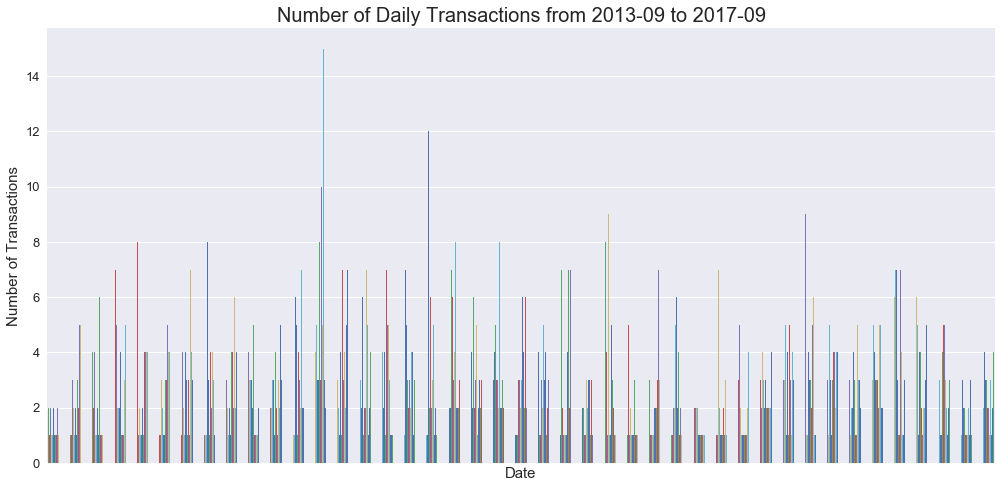

In [6]:
#group transactions by exact date
daily_trans = df.groupby('Date').count()

#plot daily transactions
ax = daily_trans['Amount'].plot(kind='bar',figsize=(17,8),fontsize=13)
ax.get_xaxis().set_ticks([])
ax.set_title("Number of Daily Transactions from 2013-09 to 2017-09", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Number of Transactions", fontsize=15)

Text(0,0.5,'Number of Transactions')

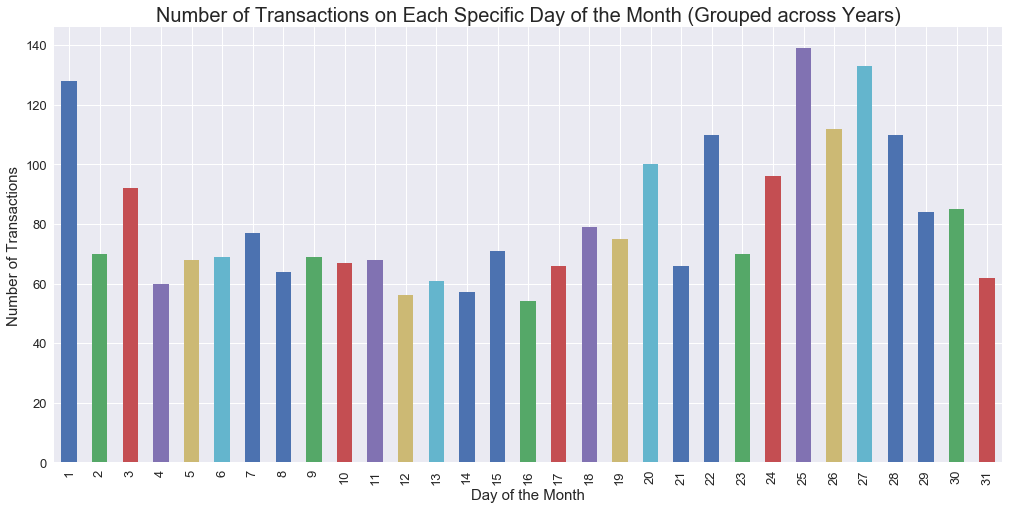

In [7]:
df['Day'] = df['Date'].dt.day
daily_trans_grouped = df.groupby('Day').count()

#plot daily transactions
ax = daily_trans_grouped['Amount'].plot(kind='bar',figsize=(17,8),fontsize=13)
ax.set_title("Number of Transactions on Each Specific Day of the Month (Grouped across Years)", fontsize=20)
ax.set_xlabel("Day of the Month", fontsize=15)
ax.set_ylabel("Number of Transactions", fontsize=15)

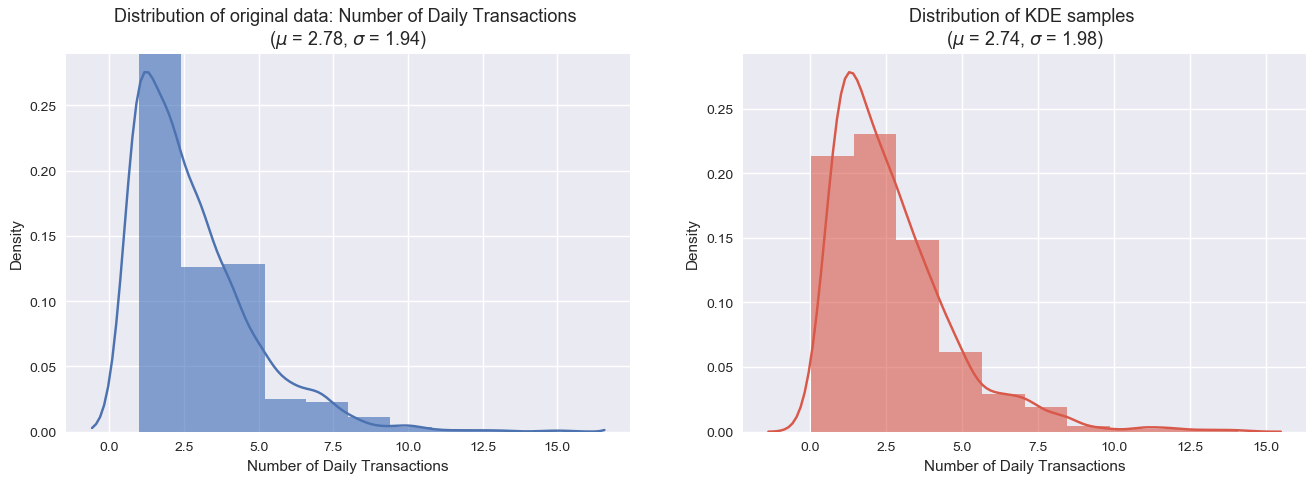

In [8]:
#daily transactions histogram: original and kde
data = daily_trans['Amount']
daily_trans_kde = KernelDensity(kernel='gaussian', bandwidth=0.4).fit(np.array(data).reshape(-1,1))
plot_density_models(data, daily_trans_kde, "Number of Daily Transactions" )

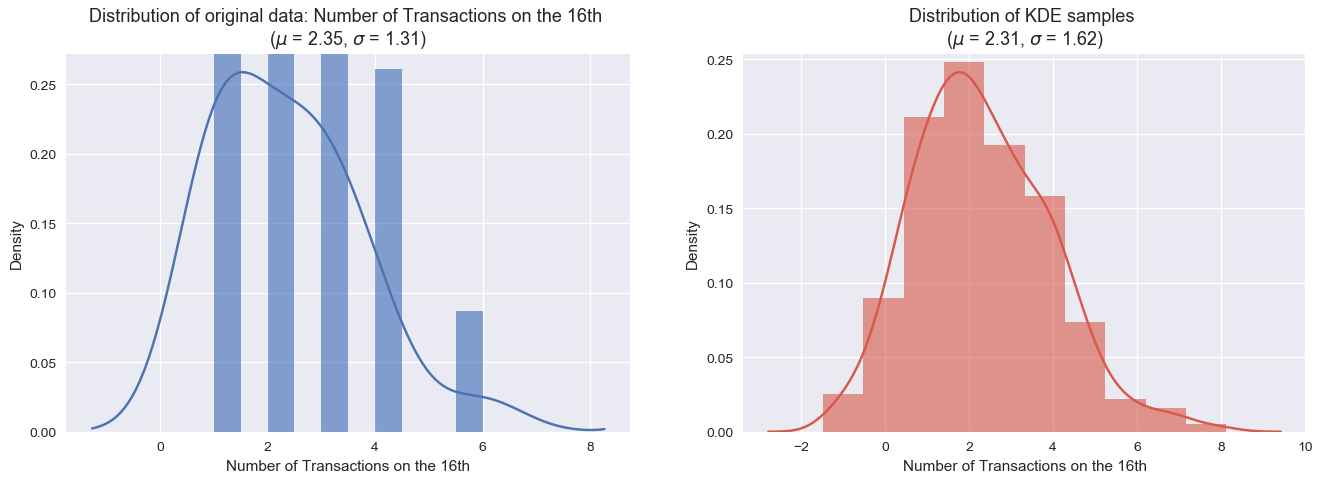

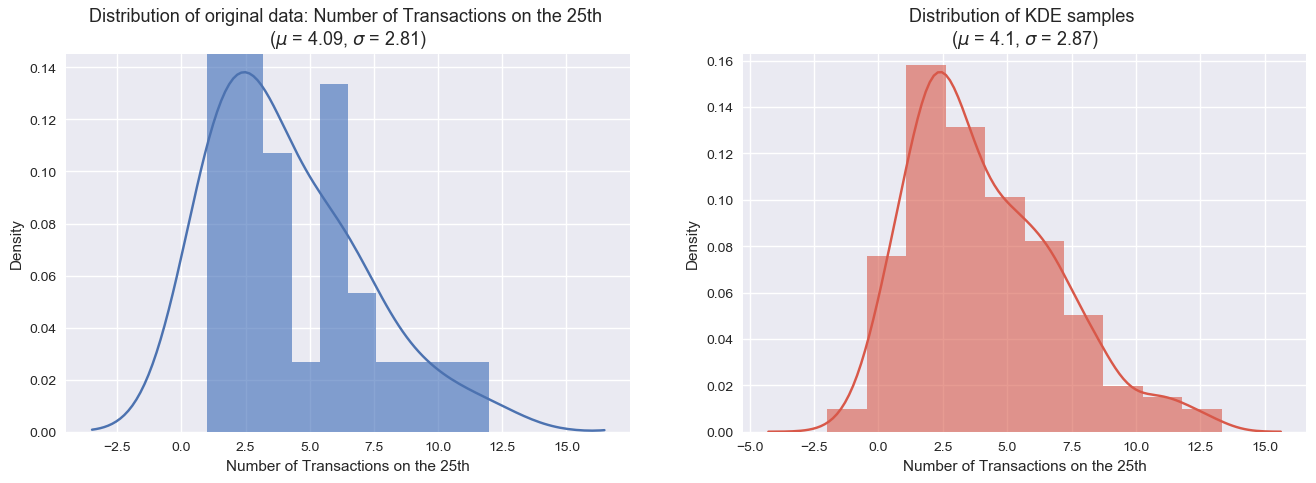

In [9]:
#get histogram and KDE of specific days to see whether there is a significant difference
def day_data_kde(df, day):
    #day specific number of transactions - grouped across 2013 - 2017
    data = df[df['Day']==day].groupby('month_year').count()['Amount']
    kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(np.array(data).reshape(-1,1))
    return data, kde

day_16 = day_data_kde(df, 16)
day_25 = day_data_kde(df, 25)

plot_density_models(day_16[0], day_16[1], "Number of Transactions on the 16th" )
plot_density_models(day_25[0], day_25[1], "Number of Transactions on the 25th" )

<h3>Analysis</h3>

<h4>Number of Monthly Transactions</h4>

From the "Number of Monthly Transactions" plot, we see a somewhat cyclic trend where the number of transactions peaks around December 2014 and January 2015, as well as December 2016 and January 2017 (note that December 2015 and January 2016 did not experience a peak). That being said, there is not enough data to ascertain whether the trend is reliable, e.g. whether there is a consistent cycle that peaks every 2 years around December and January. There is also an underlying upwards trend in transactions from 2013 to 2017, i.e. as the years increase, the overall number of transactions is also increasing. 

When the number of monthly transactions are grouped across years, we see that December has the highest number of transactions (~250) while November has the lowest (~175). There isn't a very significant difference between the highest-transaction month and the lowest-transaction month.

The monthly transactions KDE is shaped like a normal distribution with a mean of ~50.

<h4>Number of Daily Transactions</h4>

The "Number of Daily Transactions" plot is rather hard to analyze due to the sheer number of individual dates, so the number of transactions on each specific day of the month are grouped together across the years and analyzed instead. The grouped plot shows that 25th appears to have the highest number of transactions (~140), while 16th appears to have the lowest (~55). Considering the fact that about half the months in a year do not have the 31st, yet 16th still has the lowest number of transactions, it may be worth it to create day-specific KDEs for each day in the dataset (or at least, the extreme value days).

I experimented with creating day-specific KDEs to sample the number of transactions in a way that was accurate to the historical trend of that specific day of the month. However, when I created day-specific KDEs (for the 16th and 25th), I found that the distributions looked largely similar, and there was only a small difference in means (2.37 vs 3.96). In comparison, the mean for the daily transaction KDE across all different days is 2.8, albeit with a right-skew. As such, I have decided to simply use the non-specific daily transaction KDE for sampling the number of transactions that occur per day when constructing the fake data.

<h4>Summary</h4>

In creating the fake data, I have decided to use the daily transaction KDE since it will provide more granular accuracy vs the monthly transaction KDE. That is, I will be able to assign the exact number of transactions per day, as opposed to only obtaining the number of transactions at the monthly level and having to decide how to distribute the transactions across the days.

The monthly transactions KDE will be used later on to test that the sum of transaction counts across the fake days falls within a reasonable range of the monthly KDE sampling distribution.

The negligence of time-dependent trends in the fake data may arouse some suspicion, especially if the fraud is carried out over a long-term period, e.g. several months or years. However, since I will only be generating fake data for one month, I believe that the daily transaction KDE should suffice in assigning reasonably convincing number of transactions per day of fake data.


<h2>The Day in a Month that a Transaction Occured on</h2>

In comparison to the KDEs above, this KDE will map the number of times a transaction did or did not occur on a certain date.

First date in dataset: 2013-09-20 00:00:00
Last date in dataset: 2017-09-28 00:00:00


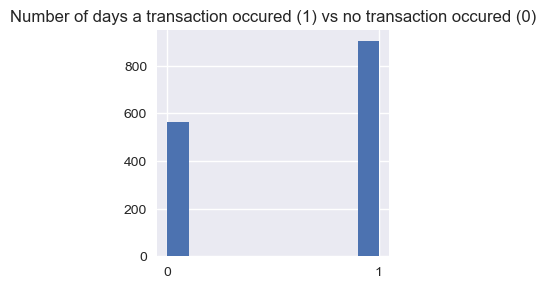

Text(0,0.5,'Number of Times At Least\n One Transaction Occured')

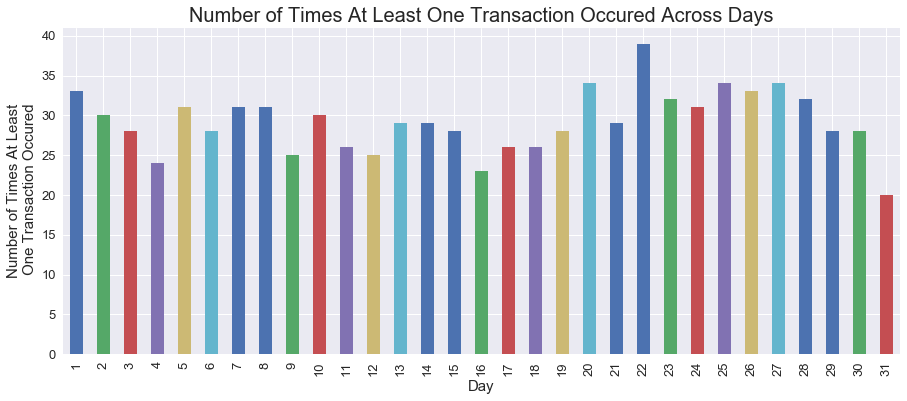

In [10]:
first_date = df.sort_values(by='Date')[:1].values[0][0]
last_date = df.sort_values(by='Date')[-1:].values[0][0]
print(f"First date in dataset: {first_date}")
print(f"Last date in dataset: {last_date}")

#get difference between two dates
time_delta = last_date - first_date

#create datelist with all days between the first and last date
datelist = pd.date_range(first_date, periods=time_delta.days)

#find days where a transaction occured
transaction_dates = list(set(datelist) & set(df['Date']))

#if transaction occured, note down '1' for transaction, else '0'
trans_occurence_lst = [1 if date in transaction_dates else 0 for date in datelist]

#create dataframe of transaction occurences
trans_occurence_df = pd.DataFrame({'Date':datelist, 'Transaction':trans_occurence_lst})
#plot the number of days a transaction occured vs no transaction occured
plt.figure(figsize=(3,3),dpi=100)
plt.hist(trans_occurence_df['Transaction'])
plt.xticks(np.arange(0,1.5,1))
plt.title("Number of days a transaction occured (1) vs no transaction occured (0)")
plt.show()

#group the transaction occurence data by days
trans_occurence_df['Day'] = trans_occurence_df['Date'].dt.day
trans_occurence_count = trans_occurence_df.groupby('Day').sum()

#plot number of times at least one transaction occured across days
ax = trans_occurence_count['Transaction'].plot(kind='bar',figsize=(15,6),fontsize=13)
ax.set_title("Number of Times At Least One Transaction Occured Across Days", fontsize=20)
ax.set_xlabel("Day", fontsize=15)
ax.set_ylabel("Number of Times At Least\n One Transaction Occured", fontsize=15)

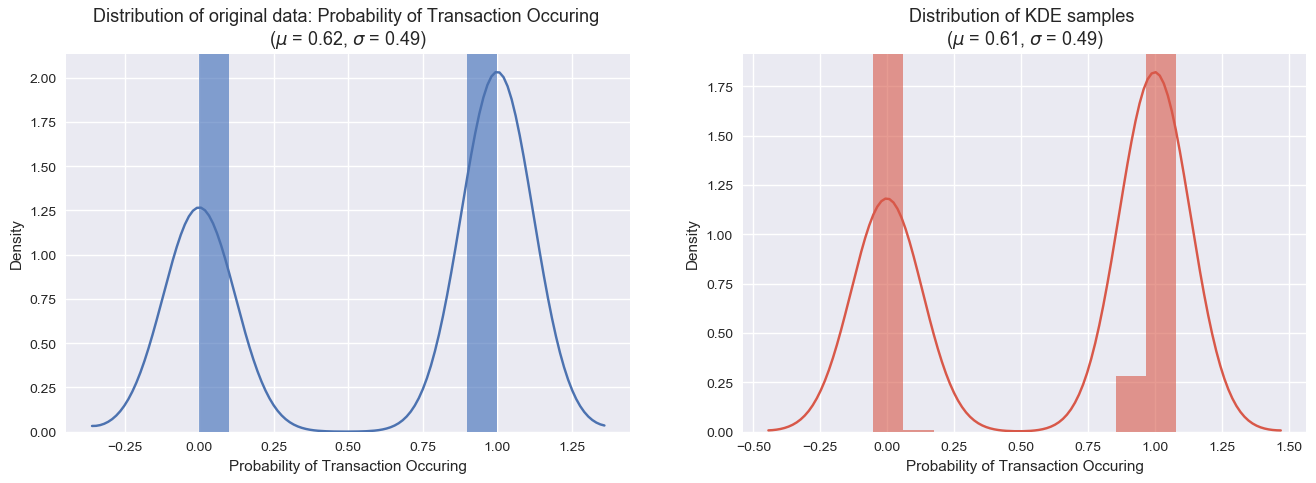

In [11]:
#transaction occurence probability: original and kde
data = trans_occurence_df['Transaction']
trans_occurence_kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(data).reshape(-1,1))
plot_density_models(data, trans_occurence_kde, "Probability of Transaction Occuring" )

<h3>Analysis</h3>

From the barplot showing the number of times at least one transaction occured across days, we see that excluding the 31st (since half the months in a year do not have the 31st), the 16th has the lowest amount of transaction occurences (~25), which also explains why the 16th has the lowest number of transactions a day. This also explains the similarity in mean between the 16th-specific KDE vs 25th-specific KDE shown earlier - on days where there _are_ transactions, the 16th has a reasonable amount of transactions, however, there are just _less days where a transaction occured_ overall.

The 22nd has the highest amount of transaction occurences (~40), which means that a transaction should almost always occur on the 22nd.

Since a visual analysis of the barplot does not show significant difference between the transaction occurences between days, the "Probability of Transaction Occuring" KDE will be used to decide the probability of a transaction occuring on a given day when creating the fake data.

Once again, while a long-con may cause suspicion if the fake data does not line-up with the time components of the real data, e.g. transactions occuring more often on the 22nd and less often on the 16th, the creation of only a month's worth of fake data according to the generated KDE should produce convincing absences and occurences of transaction days within the month.






<h2>Transaction Size</h2>

Density models at three different levels of granularity are constructed:

- The monthly transaction size
- The daily transaction size
- The transaction size per transaction

<h3>Monthly Transaction Size</h3>

Text(0,0.5,'Transaction Size')

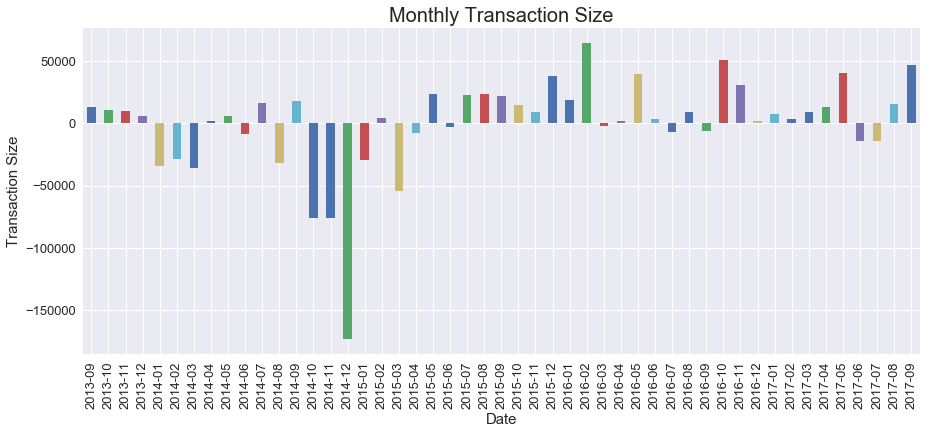

In [12]:
monthly_size = df.groupby('month_year')['Amount'].sum()

#plot mean of monthly transaction size
ax = monthly_size.plot(kind='bar',figsize=(15,6),fontsize=13)
ax.set_title("Monthly Transaction Size", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Transaction Size", fontsize=15)


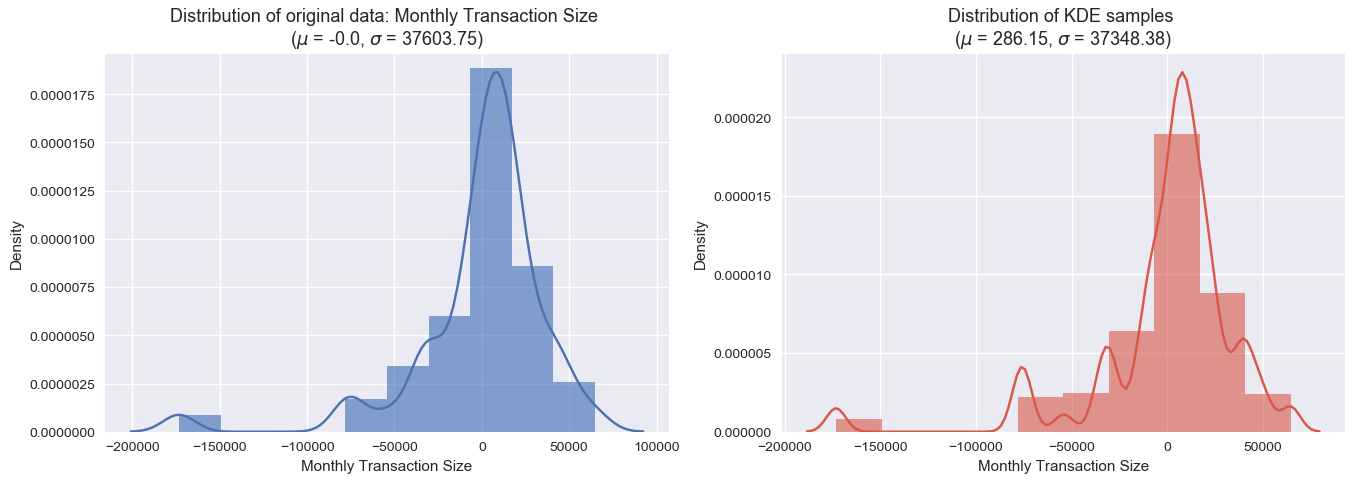

In [13]:
#monthly size histogram: original and kde
data = monthly_size
monthly_size_kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(np.array(data).reshape(-1,1))
plot_density_models(data, monthly_size_kde, "Monthly Transaction Size" )

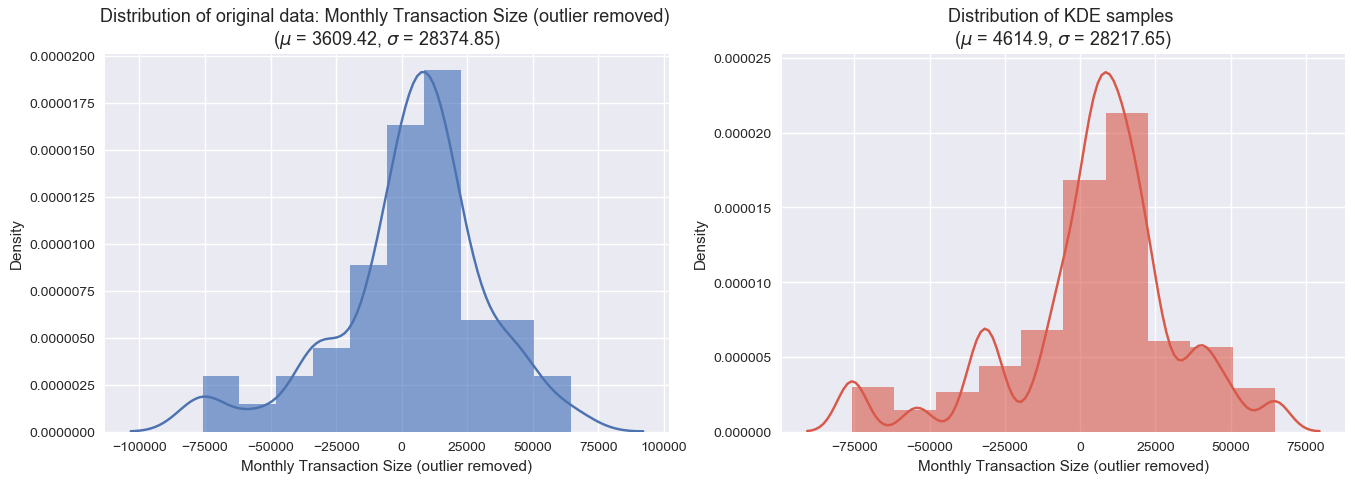

In [14]:
#remove outlier of December 2014 and view difference in KDE
monthly_size_no_outlier = monthly_size[monthly_size.index != '2014-12']

#monthly size with no outlier histogram: original and kde
data = monthly_size_no_outlier
monthly_size_no_outlier_kde = KernelDensity(kernel='gaussian', bandwidth=2.0).fit(np.array(data).reshape(-1,1))
plot_density_models(data, monthly_size_no_outlier_kde, "Monthly Transaction Size (outlier removed)" )

<h3>Daily Transaction Size</h3>

Text(0,0.5,'Transaction Size')

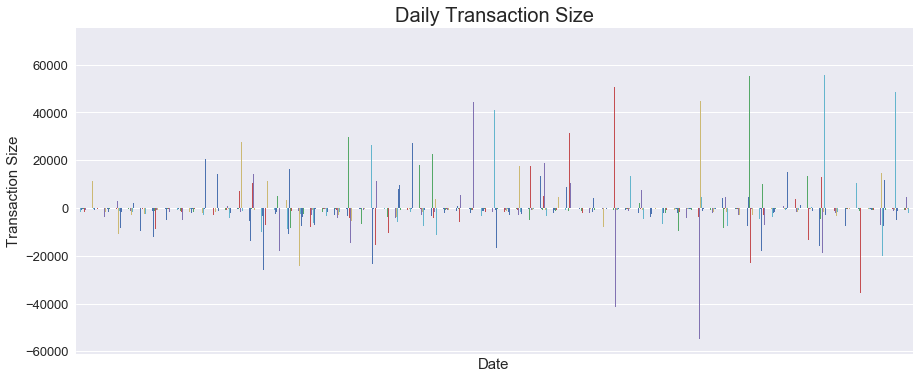

In [15]:
daily_size = df.groupby('Date')['Amount'].sum()

#plot daily transaction size
ax = daily_size.plot(kind='bar',figsize=(15,6),fontsize=13)
ax.get_xaxis().set_ticks([])
ax.set_title("Daily Transaction Size", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Transaction Size", fontsize=15)


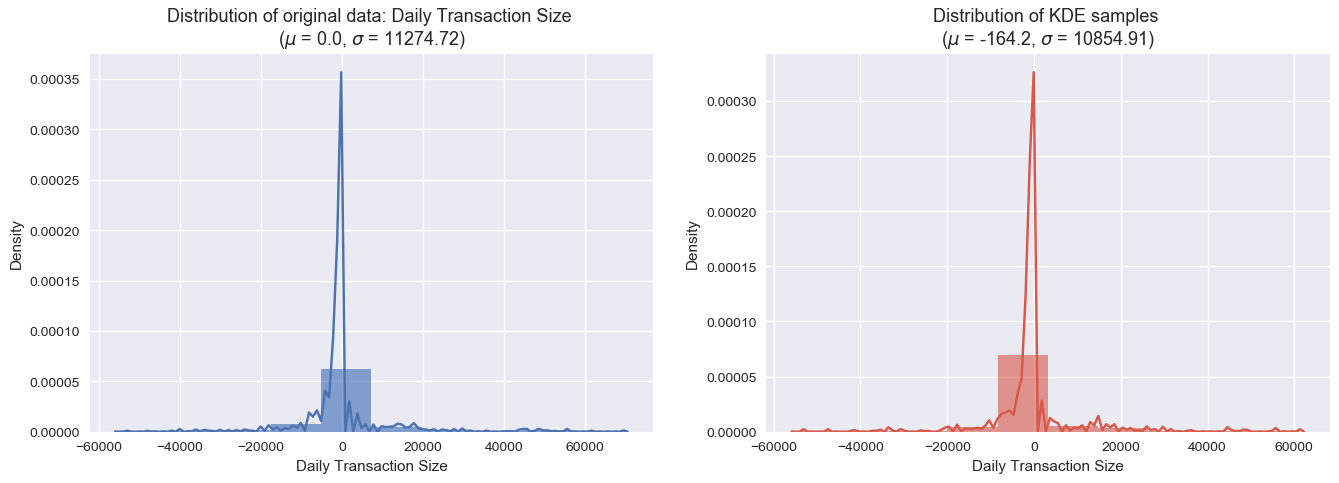

In [16]:
#daily size histogram: original and kde
data = daily_size
daily_size_kde = KernelDensity(kernel='gaussian', bandwidth=2.0).fit(np.array(data).reshape(-1,1))
plot_density_models(data, daily_size_kde, "Daily Transaction Size" )

<h3>Transaction Size per Transaction</h3>

Text(0,0.5,'Transaction Size')

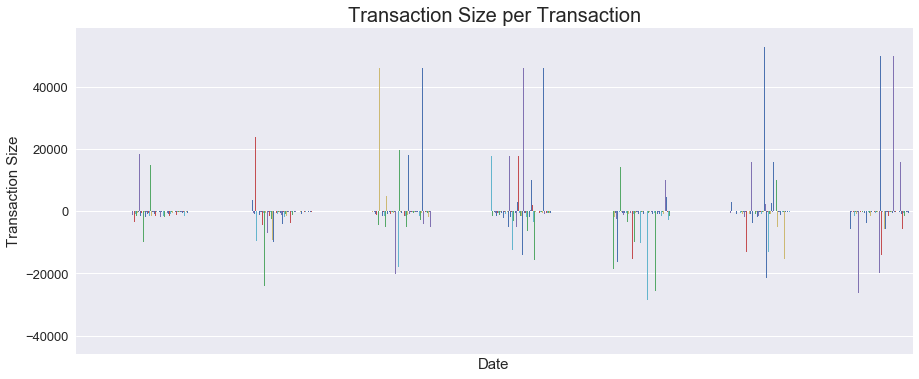

In [17]:
transaction_size = df.sort_values(by='Date')['Amount']

#plot daily transaction size
ax = transaction_size.plot(kind='bar',figsize=(15,6),fontsize=13)
ax.get_xaxis().set_ticks([])
ax.set_title("Transaction Size per Transaction", fontsize=20)
ax.set_xlabel("Date", fontsize=15)
ax.set_ylabel("Transaction Size", fontsize=15)

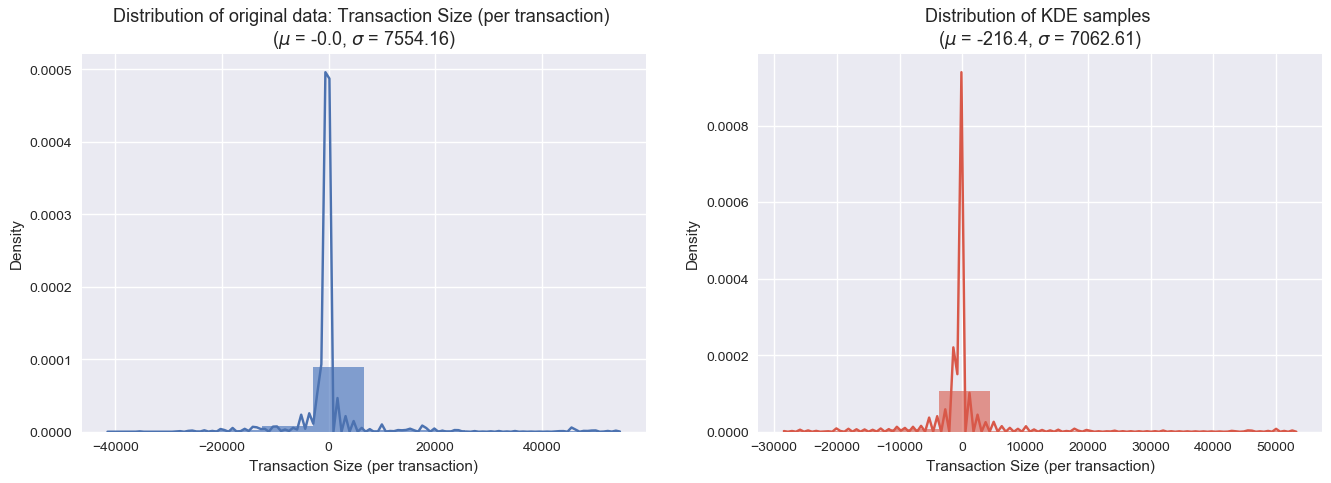

In [18]:
#transaction size (per transaction) histogram: original and kde
data = df['Amount']
transaction_size_kde = KernelDensity(kernel='gaussian', bandwidth=3.0).fit(np.array(data).reshape(-1,1))
plot_density_models(data, transaction_size_kde, "Transaction Size (per transaction)" )

<h3>Analysis</h3>

The monthly, daily, and "per transaction" transaction sizes show extreme variance, with standard deviations of ~35000, ~11000, and ~7000 repsectively. This is further emphasized by the fact that the monthly transaction size histogram has a mean of 0, while the KDE samples have a mean of -248.7. Similarly, the daily transaction size histogram has a mean of 0, while the KDE samples have a mean of -412.3; and the transaction size per transaction histogram has a mean of 0, while the KDE samples have a mean of -158.39.

<h4>Monthly Transaction Size - Removing the Monthly Outlier</h4>

The monthly transaction size time-series plot reveals an extreme dip on December 2014 that may be skewing the rest of the data. The histogram also reveals the same outlier data point on the far left of the plot. While we may expect monthly transaction sizes to differ between months, an extreme deviation is irregular and unexpected - as such, the outlier is removed and the resulting histogram and KDE re-analyzed. The new KDE has a much more stable performance - with a mean of ~4000 vs the original data mean of ~3600 (both without outliers). The standard deviation is also lowered to ~7000.

<h4>Daily Transaction Size</h4>

The daily transaction size time-series plot reveals increasing transaction sizes in the more recent years (both in income and expenses). One can almost see that the transaction size on both the positive and negative y-axes have greater magnitudes as the years progress. Since there appear to be a few extreme sizes (vs only one in the monthly transaction size), the extreme values are retained in generating the KDE. This choice is supported by the fact that the irregularity of the daily transactions appears to be prominent within the original data as well.

<h4>Transaction Size per Transaction</h4>

The transaction size per transaction time-series plot has a relatively similar pattern to the daily transaction size time-series plot. Once again, the extreme values are retained since there isn't any especially egregrious value that appears to be an outlier. The standard deviation of the KDE is ~7000, which shows a more stable performance vs the daily transaction size KDE.

<h4>Summary</h4>

In generating the fake data, the "Transaction Size per Transaction" KDE will be used to draw the transaction size since it has a smaller standard deviation than the daily size KDE. The monthly transaction size KDE will be used to check that the sum of the transaction size samples across the fictitious month do not exceed realistic boundaries of the monthly transaction size.


<h3>Create Fictitious Month of Transactions</h3>

The fictitious month of transactions will be created as follows:

1) Sample 30 times from the "Probability of Transaction Occuring" KDE to get an array of 30 days in which transactions may or may not have occured.

2) For each day that a transaction occured, sample from the "Number of Daily Transactions" KDE to get the number of transactions that occured on that day.

3) For each transaction, sample from the "Transaction size per Transaction" KDE to get the size of that transaction.

4) Check that the sum of transactions across the entire fictitious month does not exceed the 90% confidence interval of the "Monthly Transaction Size" KDE samples. If the sum of transactions exceeds the 90% confidence interval, repeat step 1, 2, and 3 to get a different set of results.

In [19]:
np.random.seed(3)

def create_fake_month():
    '''
    Returns a pandas dataframe of a month's worth (30 days) of fake transactions.
    Columns:
        Day: The day in which the transaction takes place
        Amount: The transaction amount
    '''
    #get arr of 1 and 0 to determine when a transaction occured
    trans_occured = trans_occurence_kde.sample(30).flatten().round()

    #get number of transactions that occured each day
    num_of_trans = daily_trans_kde.sample(30).flatten().round()

    #initialize fake month dictionary
    fake_month = {}
    
    #for each day in the fake month
    for i in range(len(trans_occured)):

        #if a transaction occured on that day
        if trans_occured[i] == 1: 

            #get transaction amount for each transaction that occured on that day
            transaction_amount = transaction_size_kde.sample(int(num_of_trans[i])).flatten().round(2)

            #assign the array of transaction amounts to the corresponding day
            fake_month[i+1] = transaction_amount

    #process fake_month dictionary to create fake_days and fake_transactions in dataframe format
    fake_days = []
    fake_transaction = []

    for k,v in fake_month.items():
        for i in range(len(v)):
            fake_days.append(k)
            fake_transaction.append(v[i])

    fake_df = pd.DataFrame({"Day":fake_days, "Amount":fake_transaction})
    return fake_df

fake_df = create_fake_month()
fake_df

,Day,Amount
0,1,-14004.44
1,1,-191.07
2,1,-2107.14
3,1,-63.59
4,1,-18.73
5,4,-703.25
6,4,-695.28
7,4,45884.37
8,4,-33.83
9,4,-1499.63


<h3>Compare Data to Monthly-level KDE Samples</h3>

This step is meant to demonstrate that the fake data generated from the daily samples can align with the monthly samples. It can also be used as a final-check when creating the fake monthly data to avoid producing an egregrious dataset that fits the daily criteria but does not fit the monthly criteria.

Instead of comparing the data with the KDE samples, the fake data could also simply be compared with the real data as a final step. In this case, I've just used the KDE samples to show the cohesion between the KDEs of differing levels of granularity. 

While my result here shows good alignment with the monthly level samples, i.e. we get a highly-expected fake data value that is close to the monthly mean, it should be noted that it is very possible to get data that falls outside the 90% CI as well (this happened to me a few times). In such a case, the create_fake_month() function should be run again until a dataset that satisfies the monthly comparison is created.



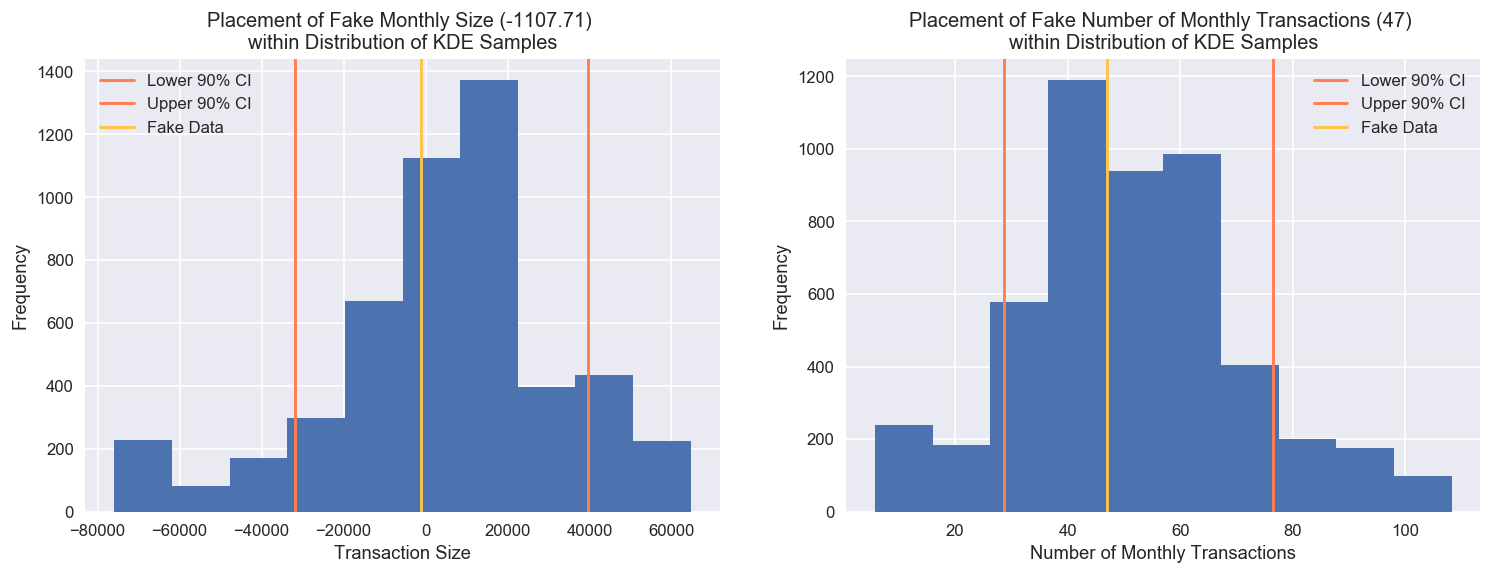

In [20]:
def compare_data(fake_data, kde, title, xlab):
    '''
    Compares the fake data to distribution of 1000 samples generated by the KDE at the monthly level.
    
    Input:
        fake_data (num): The fake data metric to be compared to the monthly-level kde distribution.
        
        kde (sklearn.neighbors.kde.KernelDensity): The monthly-level kde for sampling.
        
        title (string): The title of the resulting plot.
        
        xlabl (string): The x-axis label.
        
    Output:
        Does not return any output, but displays a plot showing the position of the fake data 
        within the distribution of KDE genenrated samples.
    
    '''
    samples = kde.sample(5000)
    CI_90 = np.percentile(samples, [10,90])

    plt.axvline(CI_90[0], color='coral', label="Lower 90% CI")
    plt.axvline(CI_90[1], color='coral', label="Upper 90% CI")
    plt.axvline(fake_data, color='#fcc546', label=f"Fake Data")
    plt.legend(loc='best')
    plt.title(f"Placement of Fake {title} ({round(fake_data,2)}) \nwithin Distribution of KDE Samples")
    plt.ylabel("Frequency")
    plt.xlabel(xlab)
    plt.hist(samples)

plt.figure(figsize=(15,5),dpi=120)
plt.subplot(1,2,1)
compare_data(fake_df['Amount'].sum(), monthly_size_no_outlier_kde, "Monthly Size","Transaction Size")
plt.subplot(1,2,2)
compare_data(len(fake_df),monthly_trans_kde,"Number of Monthly Transactions","Number of Monthly Transactions")
plt.show()

<h3>Testing Benford's Law</h3>

According to Benford's Law, we expect the numerical data to be distributed as follows:

<a title="Gknor [Public domain], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Rozklad_benforda.svg"><img width="512" alt="Rozklad benforda" src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Rozklad_benforda.svg/512px-Rozklad_benforda.svg.png"></a>

The digit 1 should appear 30% of the time, 2 should appear 17% of the time, etc.

Benford's Law is tested on the original data and the fake data.

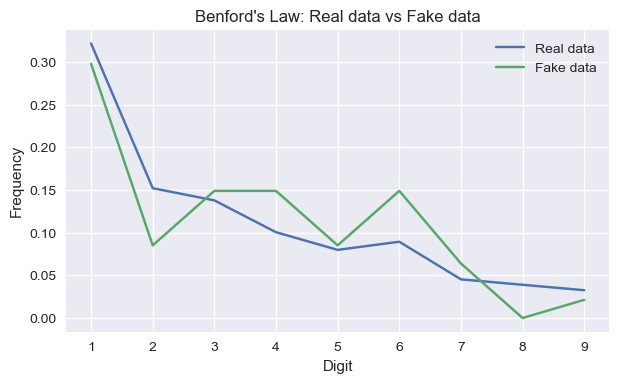

In [21]:
def benfords_law(data, label, plot=True):
    
    nums = np.arange(1,10)
    nums_str = [str(i) for i in nums]
    data_processed = data.abs().astype(str)
    
    ratios = [data_processed.str.startswith(num).sum()/len(data) for num in nums_str]

    if plot:
        plt.title(f"Benford's Law: Real data vs Fake data")
        plt.xlabel("Digit")
        plt.ylabel("Frequency")
        plt.plot(nums,ratios,label=f'{label}')
        
    return ratios

plt.figure(figsize=(7,4),dpi=100)
real_benford = benfords_law(df['Amount'], "Real data")
fake_benford = benfords_law(fake_df['Amount'], "Fake data")
plt.legend(loc='best')
plt.show()
        

<h2>Summary Analysis</h2>

Overall, I would say that the create_fake_month() function generates a reasonable set of fake data for a month. An analysis of the original transaction data shows that while there appear to be identifiable long-term trends, there is enough randomness within the data that as long as appropriate KDEs are created, a month's worth of fake data generated by sampling KDEs without a time-component should be passable.

By running the final check between the daily statistics vs the monthly statistics, I can ensure that the fake data that I created largely using daily-level KDE samples will not look out of place within the monthly-level KDE samples. As previously mentioned, a comparison can also be made with the original data before the fake monthly data is finalized to really ensure that no data falls without the 90% Confidence Interval range.

A Benford's Law test conducted on both the real and fake data shows that while the real data largely aligns with Benford's Law, the fake data has a more irregular alignment (although it does have 30% of '1s'). That being said, this could be simply because there was less fake data generated (30 counts) vs real data (2518 counts). If more fake data was generated, we might see a smoother alignment.

<h3>Model Flaws</h3>

The main flaw of this model is that it does not consider any time-dependency within the data. As mentioned in the sections above, there may be clear long-term trends within the data due to the individual earning more income, economic patterns, etc. Similarly, there may also be short-term trends such as a tendency to spend more on paycheck days, and a tendency to spend less towards the end of the month. Since the fake data was generated using samples from the KDEs that only take data-frequency into account without considering a time-component, a forensic consultant could potentially identify the fakeness of the data when comparing the timeline trends. As such, I still believe that a month's worth of fake data should be able to fly under the radar, but long-term data generation could lead to rather evident fakeness.

Another time component that was not discussed is the exact time of the transaction itself. This wasn't considered at all within the model (since it wasn't available in the data), but assuming that the forensic consultant has access to time records, e.g. hour, minute, second, of the transactions, a model that does not generate time data could be immediately identified as fake. For example, if we perform all these transactions successively at 3am, that may raise alarms when the individual normally spaces out their transactions within the daytime.

